# Undulator optimization through rsopt 

This directory includes files to run an optimization procedure on the TESSA undulator. This optimization runs through the rsopt package and shows an alternative to the matrix inversion procedure used in example_undulator_tune.ipynb.


If you want to run the example you can just enter in a terminal (assuming rsopt is installed):
```rsopt optimize configuration start_config.yml```

- The first portion of this notebook includes code that was used to make start_config.yml. Since there are over 100 parameters it easier to automatically generate the configuration file in this case.

- The second half of this notebook shows the analysis of the optimizer result

### Make dictionary of offset parameters
Optimization parameters are passed to by rsopt to the evaluation function as keyword arguments.
Here we set names for the parameters and their starting values and minimum/maximum.

In [1]:
min_os_ee = -0.2
max_os_ee =  0.2
size = 9
os_ee_starting_point = {'{}_{}'.format(name, i): [0.0, min_os_ee, max_os_ee] for name in ['corree_-x', 'corree_+x', 'corree_-z', 'corree_+z'] for i in range(size)}

min_os = -0.2
max_os =  0.2
size = 32
os_starting_point = {'{}_{}'.format(name, i): [0.0, min_os, max_os] for name in ['corr_-x', 'corr_+x', 'corr_-z', 'corr_+z'] for i in range(size)}

In [2]:
starting_point = {**os_ee_starting_point, **os_starting_point}

### Make Configuration File

In [3]:
# Define optimization method and run setup
method = """        setup:
            execution_type: serial
            input_file: tessa.py
            function: eval_f
options:
    software: dfols
    method: dfols
    record_interval: 5
    components: 43
    software_options: {'do_logging': False,
                     'rhoend': 1e-5,
                     'user_params': {'model.abs_tol': 1e-10,
                                     'model.rel_tol': 1e-4
                                    }
                     }
    exit_criteria:
        sim_max: 300"""

In [4]:
# Write optimization parameters to file with setup and options
header = """codes:
    - python:
        parameters:
"""
pars = """            {name}:
                min: {minv}
                max: {maxv}
                start: {start}
"""
config_str = header
for key, val in starting_point.items():
    config_str += pars.format(name=key, minv=val[1], maxv=val[2], start=val[0])
with open('start_config.yml', 'w') as ff:
    config_str += method
    ff.write(config_str)

# Result Analysis

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# Load log of the optimization run - an example of the results is included 
#  or you can enter a new filename if you ran rsopt

history_file_name = 'example_results/libE_history_for_run_starting_2021-05-20_18:03:19.947_after_sim_300.npy'
H = np.load(history_file_name)

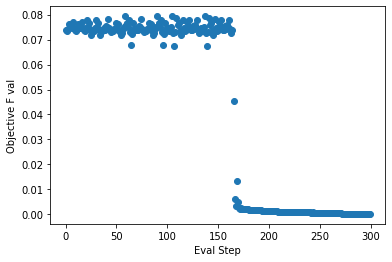

In [48]:
# Plot history of the objective function through the optimization
plt.figure()
plt.scatter(H['sim_id'], H['f'])
plt.xlabel('Eval Step')
plt.ylabel('Objective F val')
plt.show()

# Show the Result from the Optimization

In [57]:
best_index = np.argmin(H['f'])
best_index

297

In [51]:
xval = H['x'][best_index]

### Convert from parameter array back to the dictionaries needed to make the undulator

In [52]:
# Process inputs
corr_ee_size = 9
corr_size = 32
corr_ee = {'-x': [], '+x': [], '-z': [], '+z': []}
corr = {'-x': [], '+x': [], '-z': [], '+z': []}

index = 0
for key, val in corr_ee.items():
    for i in range(corr_ee_size):
        corr_ee[key].append(xval[index + i])
    index += corr_ee_size
for key, val in corr.items():
    for i in range(corr_size):
        corr[key].append(xval[index + i])
    index += corr_size


In [53]:
for it in [corr, corr_ee]:
    for key, val in it.items():
        it[key] = np.array(val)

### Make undulator and plot result

In [54]:
from tessa import local_make_und, calc_pole_kund, GAP_OS_ideal, GAP_OS_EE_ideal, UND_NUMPER

In [55]:
und_ideal = local_make_und(0.0, 0.0, GAP_OS_ideal, GAP_OS_EE_ideal, loadmags=False, UND_NUMPER=UND_NUMPER)
calc_pole_kund(und_ideal)
local_und = local_make_und(0.0, 0.052359877, corr, corr_ee, rngseed=42, loadmags=False, UND_NUMPER=UND_NUMPER)
calc_pole_kund(local_und)

0

### Load Data from Matrix Inversion Method

In [58]:
pos_uncorr, uncorr_ku = np.load('example_results/uncorrected_ku.npy')
pos_corr, corr_ku = np.load('example_results/corrected_ku.npy')

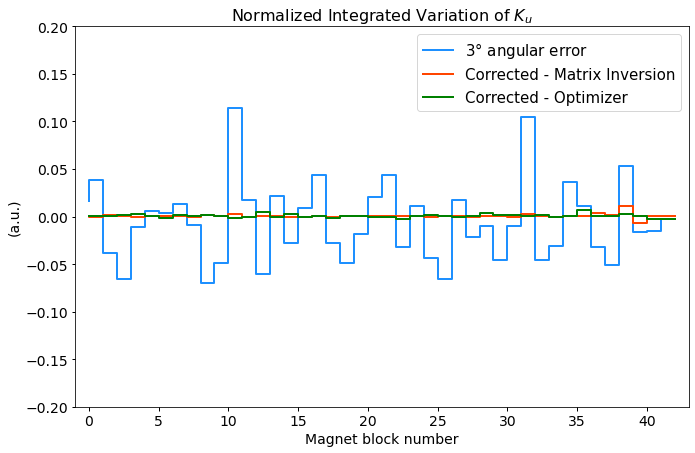

In [61]:
fig, ax = plt.subplots(figsize=(11,7))
ls = dict(linewidth=2,linestyle='-',marker='o',ms=0, alpha=1)

ls['color'] = 'dodgerblue'
ax.step(pos_uncorr, uncorr_ku, **ls)
#
ls['color'] = 'orangered'
ax.step(pos_corr, corr_ku, **ls)
# 
ls['color'] = 'green'
ax.step(und_ideal.polekund[:,3], local_und.polekund[:,2]-und_ideal.polekund[:,2], **ls)
#


ax.axis([-1,43, -0.2,0.2])

fs = dict(fontsize=14)
plt.xlabel('Magnet block number',**fs)
plt.ylabel('(a.u.)', **fs)
plt.title('Normalized Integrated Variation of $K_u$', fontsize=16)
legloc = 'best'
plt.legend(['$3 \\degree$ angular error ', 'Corrected - Matrix Inversion', 'Corrected - Optimizer'], fontsize=15,loc=legloc)

ax.tick_params(labelcolor='k', labelsize=14, width=1)

ax.grid(False)
plt.show()